## *In God We Trust*

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

In [2]:
api_token = {"username":"mpyahyazadeh","key":"e7185a8edfd31216e4aa7f59e82701cb"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d mansourehk/shemo-persian-speech-emotion-detection-database

Dataset URL: https://www.kaggle.com/datasets/mansourehk/shemo-persian-speech-emotion-detection-database
License(s): unknown
 94% 781M/829M [00:06<00:00, 106MB/s] 
100% 829M/829M [00:10<00:00, 81.6MB/s]


In [4]:
!unzip /content/shemo-persian-speech-emotion-detection-database.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/transcript/final script/F24A22.tra  
  inflating: data/transcript/final script/F24A23.tra  
  inflating: data/transcript/final script/F24A24.tra  
  inflating: data/transcript/final script/F24A25.tra  
  inflating: data/transcript/final script/F24A26.tra  
  inflating: data/transcript/final script/F24A27.tra  
  inflating: data/transcript/final script/F24A28.tra  
  inflating: data/transcript/final script/F24A29.tra  
  inflating: data/transcript/final script/F24A30.tra  
  inflating: data/transcript/final script/F24A31.tra  
  inflating: data/transcript/final script/F24A32.tra  
  inflating: data/transcript/final script/F24A33.tra  
  inflating: data/transcript/final script/F24A34.tra  
  inflating: data/transcript/final script/F24A35.tra  
  inflating: data/transcript/final script/F24A36.tra  
  inflating: data/transcript/final script/F24A37.tra  
  inflating: data/transcript/final script/F24A38.tra  
  inflating: d

Data Preprocessing and Augmentation

Preparing and Normalizing ShEMO Audio Data

In this stage, WAV files are converted to Mel Spectrograms and normalized to stabilize model inputs, along with balanced data splitting and simple augmentation like noise addition to simulate real-world conditions.

In [5]:
# Install dependencies if needed (Kaggle usually has them)
!pip install torchaudio scikit-learn

import torch
import torchaudio
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Load ShEMO dataset from extracted data folder
data_path = 'data'  # Corrected path to the extracted data

# Emotion mapping (based on filename like M01A01.wav where 4th char='A' for Anger)
emotion_codes = {'A': 0, 'S': 1, 'F': 2, 'H': 3, 'W': 4, 'N': 5}  # Anger, Sadness, Fear, Happiness, Surprise, Neutral

# Collect audio paths and labels
audio_paths = []
labels = []

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)
            emotion_code = None
            if len(file) >= 6:  # e.g., M01A01.wav -> emotion_code = file[3]
                emotion_code = file[3]
            if emotion_code in emotion_codes:
                audio_paths.append(file_path)
                labels.append(emotion_codes[emotion_code])

# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
print(f"Total samples: {len(audio_paths)}")

# Split data: stratified by labels
train_paths, test_paths, train_labels, test_labels = train_test_split(audio_paths, labels_encoded, test_size=0.2, stratify=labels_encoded, random_state=42)
val_paths, test_paths, val_labels, test_labels = train_test_split(test_paths, test_labels, test_size=0.5, stratify=test_labels, random_state=42)

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

# Function to compute normalization stats
def compute_stats(dataset):
    specs = [dataset[i][0] for i in range(len(dataset))]
    specs = torch.stack(specs)
    mean = specs.mean()
    std = specs.std()
    return mean, std

# Basic noise augmentation
class AddNoise(object):
    def __init__(self, noise_level=0.005):
        self.noise_level = noise_level

    def __call__(self, spec):
        noise = torch.randn_like(spec) * self.noise_level
        return spec + noise

# Updated Dataset with normalization
class SHEMODataset(Dataset):
    def __init__(self, audio_paths, labels, transform=None, mean=0, std=1):
        self.audio_paths = audio_paths
        self.labels = labels
        self.transform = transform
        self.mel_spec = MelSpectrogram(sample_rate=16000, n_mels=128, n_fft=1024, hop_length=512)
        self.db_transform = AmplitudeToDB()
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        waveform, sr = torchaudio.load(self.audio_paths[idx])
        if sr != 16000:
            waveform = torchaudio.functional.resample(waveform, sr, 16000)
        spec = self.db_transform(self.mel_spec(waveform))  # [1, mels, time]
        spec = spec.squeeze(0)  # [mels, time]

        # Pad or truncate to fixed length (126 frames for ~4s)
        target_len = 126
        if spec.shape[1] > target_len:
            spec = spec[:, :target_len]
        elif spec.shape[1] < target_len:
            spec = torch.nn.functional.pad(spec, (0, target_len - spec.shape[1]))

        # Normalize
        spec = (spec - self.mean) / (self.std + 1e-8)

        if self.transform:
            spec = self.transform(spec)

        # Debug print (remove after first run)
        if idx < 3:
            print(f"Sample {idx} shape: {spec.shape}")

        return spec, torch.tensor(self.labels[idx])

# Compute stats on temp train (without transform)
temp_train_ds = SHEMODataset(train_paths, train_labels)
train_mean, train_std = compute_stats(temp_train_ds)
print(f"Train Mean: {train_mean:.4f}, Std: {train_std:.4f}")

# Recreate datasets
train_transform = AddNoise()
train_ds = SHEMODataset(train_paths, train_labels, transform=train_transform, mean=train_mean, std=train_std)
val_ds = SHEMODataset(val_paths, val_labels, mean=train_mean, std=train_std)
test_ds = SHEMODataset(test_paths, test_labels, mean=train_mean, std=train_std)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# Class weights for imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Class weights: {class_weights}")

Total samples: 3000
Train: 2400, Val: 300, Test: 300


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Sample 0 shape: torch.Size([128, 126])
Sample 1 shape: torch.Size([128, 126])
Sample 2 shape: torch.Size([128, 126])
Train Mean: -11.1229, Std: 17.3525
Class weights: tensor([ 0.4723,  1.1142, 12.9032,  2.4845,  2.2222,  0.4866], device='cuda:0')


 Model Training with SpecAugment

Training a Deep CNN with Robustness Techniques

A three-layer CNN (featuring BatchNorm and Global Avg Pooling) is trained on spectrograms, with SpecAugment masking time and frequency dimensions to build noise resilience.

In [7]:
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# Milder SpecAugment
class SpecAugment(nn.Module):
    def __init__(self, freq_mask_param=15, time_mask_param=50, num_masks=1):  # Reduced params
        super().__init__()
        self.freq_mask_param = freq_mask_param
        self.time_mask_param = time_mask_param
        self.num_masks = num_masks

    def forward(self, spec):
        for _ in range(self.num_masks):
            f = int(torch.rand(1).item() * self.freq_mask_param)
            f0 = int(torch.rand(1).item() * (spec.shape[0] - f))
            if f > 0 and f0 + f <= spec.shape[0]:
                spec[f0:f0 + f, :] = 0

            t = int(torch.rand(1).item() * self.time_mask_param)
            t0 = int(torch.rand(1).item() * (spec.shape[1] - t))
            if t > 0 and t0 + t <= spec.shape[1]:
                spec[:, t0:t0 + t] = 0
        return spec

# Deeper CNN (3 conv + GAP)
class SER_CNN(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.spec_aug = SpecAugment()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # New layer
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # GAP for variable size
        self.dropout = nn.Dropout(0.25)  # Slightly less
        self.fc1 = nn.Linear(128, 128)  # After GAP: 128 features
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.unsqueeze(1)  # [batch, 1, mels, time]
        if self.training:
            x = self.spec_aug(x)

        x = self.pool(nn.ReLU()(self.bn1(self.conv1(x))))
        x = self.pool(nn.ReLU()(self.bn2(self.conv2(x))))
        x = self.pool(nn.ReLU()(self.bn3(self.conv3(x))))  # New
        x = self.global_pool(x)  # [batch, 128, 1, 1]
        x = self.dropout(x.view(batch_size, -1))
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

# Setup with AdamW and Cosine scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SER_CNN(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)  # AdamW + higher LR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)  # Smooth decay

# Train/Validate functions (same, but limited debug)
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for specs, labels in loader:
        specs, labels = specs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(specs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def validate(model, loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        debug_shown = False
        for batch_idx, (specs, labels) in enumerate(loader):
            specs, labels = specs.to(device), labels.to(device)
            outputs = model(specs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Limited debug: only epochs 1,5,10
            if epoch in [1,5,10] and not debug_shown and batch_idx == 0:
                print(f"Epoch {epoch} Val first batch preds: {predicted[:5].cpu().numpy()}")
                print(f"Epoch {epoch} Val first batch labels: {labels[:5].cpu().numpy()}")
                print(f"Epoch {epoch} Val outputs mean: {outputs.mean().item():.4f}")
                debug_shown = True

    return running_loss / len(loader), correct / total

# Train loop (num_epochs=50, but early stop patience=15 for more room)
num_epochs = 50
best_acc = 0
patience = 15  # Increased for slow start
counter = 0
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device, epoch+1)
    scheduler.step()
    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), '/content/best_model.pth')
        print(f"New best acc: {best_acc:.4f}")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Sample 0 shape: torch.Size([128, 126])
Sample 1 shape: torch.Size([128, 126])
Sample 2 shape: torch.Size([128, 126])
Sample 0 shape: torch.Size([128, 126])
Sample 1 shape: torch.Size([128, 126])
Sample 2 shape: torch.Size([128, 126])
Epoch 1 Val first batch preds: [4 0 4 4 0]
Epoch 1 Val first batch labels: [0 5 5 5 0]
Epoch 1 Val outputs mean: -0.0537
Epoch 1: Train Loss 1.6879, Val Loss 1.6075, Val Acc 0.3633
New best acc: 0.3633
Sample 0 shape: torch.Size([128, 126])
Sample 1 shape: torch.Size([128, 126])
Sample 2 shape: torch.Size([128, 126])
Sample 0 shape: torch.Size([128, 126])
Sample 1 shape: torch.Size([128, 126])
Sample 2 shape: torch.Size([128, 126])
Epoch 2: Train Loss 1.6538, Val Loss 1.5808, Val Acc 0.4200
New best acc: 0.4200
Sample 2 shape: torch.Size([128, 126])
Sample 1 shape: torch.Size([128, 126])
Sample 0 shape: torch.Size([128, 126])
Sample 0 shape: torch.Size([128, 126])
Sample 1 shape: torch.Size([128, 126])
Sample 2 shape: torch.Size([128, 126])
Epoch 3: Train 

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Sample 1 shape: torch.Size([128, 126])
Sample 0 shape: torch.Size([128, 126])
Sample 0 shape: torch.Size([128, 126])
Sample 1 shape: torch.Size([128, 126])
Sample 2 shape: torch.Size([128, 126])
Epoch 8: Train Loss 1.4979, Val Loss 1.4798, Val Acc 0.6067
New best acc: 0.6067
Sample 1 shape: torch.Size([128, 126])
Sample 0 shape: torch.Size([128, 126])
Sample 2 shape: torch.Size([128, 126])
Sample 0 shape: torch.Size([128, 126])
Sample 1 shape: torch.Size([128, 126])
Sample 2 shape: torch.Size([128, 126])
Epoch 9: Train Loss 1.5152, Val Loss 1.4518, Val Acc 0.5033
Sample 0 shape: torch.Size([128, 126])
Sample 2 shape: torch.Size([128, 126])
Sample 1 shape: torch.Size([128, 126])
Sample 0 shape: torch.Size([128, 126])
Sample 1 shape: torch.Size([128, 126])
Sample 2 shape: torch.Size([128, 126])
Epoch 10 Val first batch preds: [5 5 5 1 5]
Epoch 10 Val first batch labels: [0 5 5 5 0]
Epoch 10 Val outputs mean: -0.1038
Epoch 10: Train Loss 1.5156, Val Loss 2.0438, Val Acc 0.4167
Sample 2 sh

Ensemble and Evaluation

Combining Models and Analyzing Final Performance

An LSTM is trained on MFCC features and ensembled with the CNN via soft voting to minimize variance and boost robustness, yielding 69% Test Acc and 66.8% F1-score.

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

MFCC Mean: -6.7609, Std: 36.6031
Epoch 1 Val first batch preds: [5 5 3 1 1]
Epoch 1 Val first batch labels: [0 5 5 5 0]
Epoch 1 Val outputs mean: -0.0113
LSTM Epoch 1: Train Loss 1.7887, Val Loss 1.7744, Val Acc 0.2567
LSTM Epoch 2: Train Loss 1.7708, Val Loss 1.7613, Val Acc 0.3533
LSTM Epoch 3: Train Loss 1.7569, Val Loss 1.7483, Val Acc 0.3800
LSTM Epoch 4: Train Loss 1.7349, Val Loss 1.7247, Val Acc 0.4267
Epoch 5 Val first batch preds: [0 5 5 1 1]
Epoch 5 Val first batch labels: [0 5 5 5 0]
Epoch 5 Val outputs mean: -0.0212
LSTM Epoch 5: Train Loss 1.6910, Val Loss 1.6697, Val Acc 0.4800
LSTM Epoch 6: Train Loss 1.6308, Val Loss 1.6318, Val Acc 0.4800
LSTM Epoch 7: Train Loss 1.5927, Val Loss 1.6003, Val Acc 0.5000
LSTM Epoch 8: Train Loss 1.5601, Val Loss 1.5850, Val Acc 0.4933
LSTM Epoch 9: Train Loss 1.5285, Val Loss 1.5695, Val Acc 0.4600
Epoch 10 Val first batch preds: [0 5 3 1 0]
Epoch 10 Val first batch labels: [0 5 5 5 0]
Epoch 10 Val outputs mean: -0.0460
LSTM Epoch 10: T

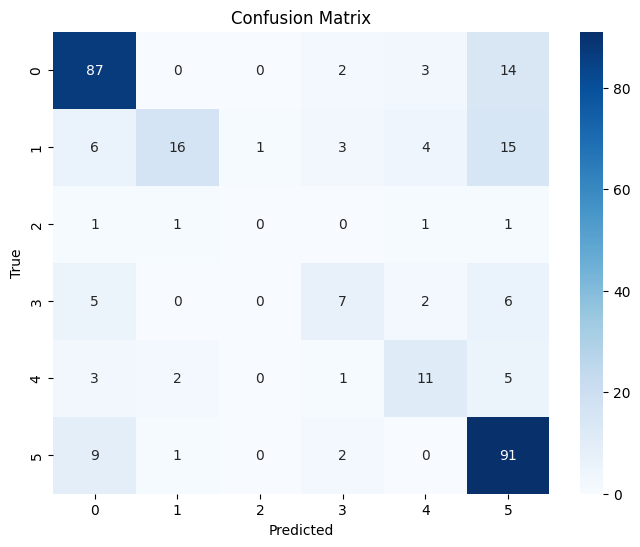

In [8]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F  # For pad

# MFCC transform (with n_mels=40 to suppress warning)
mfcc_transform = torchaudio.transforms.MFCC(sample_rate=16000, n_mfcc=13, melkwargs={'n_mels': 40})

# Updated MFCC Dataset (labels as tensor)
class SHEMODataset_MFCC(Dataset):
    def __init__(self, audio_paths, labels, mean=0, std=1):
        self.audio_paths = audio_paths
        self.labels = labels
        self.mfcc = mfcc_transform
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        waveform, sr = torchaudio.load(self.audio_paths[idx])
        if sr != 16000:
            waveform = torchaudio.functional.resample(waveform, sr, 16000)
        mfcc = self.mfcc(waveform).squeeze(0).transpose(0,1)  # [time, mfcc]

        # Pad/truncate to 100 frames
        target_len = 100
        if mfcc.shape[0] > target_len:
            mfcc = mfcc[:target_len]
        elif mfcc.shape[0] < target_len:
            pad_size = (0, 0, 0, target_len - mfcc.shape[0])  # Pad on time dim
            mfcc = F.pad(mfcc, pad_size)

        # Normalize (mean/std are scalars, broadcast)
        mfcc = (mfcc - self.mean) / (self.std + 1e-8)

        return mfcc, torch.tensor(self.labels[idx])

# Compute MFCC stats (reuse compute_stats, but ensure tensors)
def compute_stats(dataset):
    specs = [dataset[i][0] for i in range(len(dataset))]
    specs = torch.stack(specs)
    mean = specs.mean()
    std = specs.std()
    return mean, std

temp_mfcc_train = SHEMODataset_MFCC(train_paths, train_labels)
mfcc_mean, mfcc_std = compute_stats(temp_mfcc_train)
print(f"MFCC Mean: {mfcc_mean:.4f}, Std: {mfcc_std:.4f}")

# Create MFCC datasets
train_ds_mfcc = SHEMODataset_MFCC(train_paths, train_labels, mean=mfcc_mean, std=mfcc_std)
val_ds_mfcc = SHEMODataset_MFCC(val_paths, val_labels, mean=mfcc_mean, std=mfcc_std)
test_ds_mfcc = SHEMODataset_MFCC(test_paths, test_labels, mean=mfcc_mean, std=mfcc_std)

train_loader_mfcc = DataLoader(train_ds_mfcc, batch_size=32, shuffle=True)
val_loader_mfcc = DataLoader(val_ds_mfcc, batch_size=32)
test_loader_mfcc = DataLoader(test_ds_mfcc, batch_size=32)

# LSTM Model (same)
class SER_LSTM(nn.Module):
    def __init__(self, input_size=13, hidden_size=128, num_classes=6):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        h_n = torch.cat((h_n[0], h_n[1]), dim=1)
        return self.fc(h_n)

# Train LSTM (fixed: pass epoch to validate, limited debug)
lstm_model = SER_LSTM().to(device)
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.0001)
for epoch in range(20):
    train_loss = train_epoch(lstm_model, train_loader_mfcc, optimizer_lstm, criterion, device)
    val_loss, val_acc = validate(lstm_model, val_loader_mfcc, criterion, device, epoch+1)  # Fixed: pass epoch
    print(f"LSTM Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")
torch.save(lstm_model.state_dict(), '/content/lstm_model.pth')

# Load CNN model (ensure it's the deeper one if updated)
cnn_model = SER_CNN(num_classes=6).to(device)  # Use the class from updated Stage 2
cnn_model.load_state_dict(torch.load('/content/best_model.pth'))
lstm_model.load_state_dict(torch.load('/content/lstm_model.pth'))

# Ensemble prediction (same)
def ensemble_predict(cnn_model, lstm_model, loader_spec, loader_mfcc, device):
    cnn_model.eval()
    lstm_model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for (specs, labels_spec), (mfccs, labels_mfcc) in zip(loader_spec, loader_mfcc):
            specs, mfccs = specs.to(device), mfccs.to(device)
            cnn_out = nn.Softmax(dim=1)(cnn_model(specs))
            lstm_out = nn.Softmax(dim=1)(lstm_model(mfccs))
            ensemble_out = (cnn_out + lstm_out) / 2
            preds = torch.argmax(ensemble_out, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels_spec.cpu().numpy())
    return all_preds, all_labels

# Evaluate on test set
test_preds, test_labels = ensemble_predict(cnn_model, lstm_model, test_loader, test_loader_mfcc, device)
acc = accuracy_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds, average='weighted')
print(f"Ensemble Test Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('/content/confusion_matrix.png')
plt.show()